In [234]:
import numpy as np
import sympy as sp
import scipy as scpy
import ipywidgets

from matplotlib import pyplot
%matplotlib inline

In [235]:
sp.init_printing()
(u_max, u_star, rho_max, rho_star, A, B) = sp.symbols('u_max u_star rho_max rho_star A B')

In [236]:
u_max

### Below, find the 3 conditional equations

In [237]:
eq1 = sp.Eq(0, u_max * rho_max * (1 - A*rho_max - B*rho_max**2))
# Eq command from sympy library. (RHS, LHS)
eq2 = sp.Eq(0, u_max * (1 - 2*A*rho_star - 3*B*rho_star**2))

eq3 = sp.Eq(u_star, u_max * (1 - A*rho_star - B*rho_star**2))

In [238]:
eq1

In [239]:
eq2

In [240]:
eq3

### Above is the 3 conditional equations

In [241]:
eq4 = sp.Eq(eq2.lhs - 3*eq3.lhs, eq2.rhs - 3*eq3.rhs)
# This is how we will use Sympy to make algebraic actions
# Equation 4 is how we will solve for B later, Eq4 eliminates B (one less unknown) by subtracting 3*Eq3 from the second equation
eq4

In [242]:
eq4 = eq4.simplify()
# This will simplify the above equation
eq4 = eq4.expand()
# After simplifying, we can use expand in order to see all terms w/o any parenthesis
eq4
# Eq4 allows us to solve for A in terms of rho_star without B in the expression

In [243]:
# Now we can solve the equations for their specified variable.
# Let's solve eq4 for rho_star. sympy's solve function takes in the form (equation_you_solve, variable_solving_for)
rho_sol = sp.solve(eq4, rho_star)[0]
# we could add [0] at the end of the above equation to obtain the 0th element, but its the same as above, (ask Olivier)
rho_sol

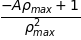

In [244]:
# Now we can solve for the first constant, B utilizing equation 1
B_solution = sp.solve(eq1, B)[0]
B_solution

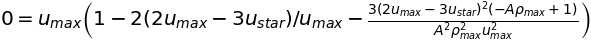

In [245]:
# Utilizing the subs function from sympy
quadA = eq2.subs([(rho_star, rho_sol), (B, B_solution)])
quadA


#How Subs works:
#subs(old, new) in pairs. new expression is substituting the old one. (Above,
#rho_sol is replacing rho_star; and B_solution is replacing B);


#UPDATE ON [0], necessary |for subs to work properly in this cell. 

In [246]:
eq5 = quadA.simplify()
# Quadratic in A is now simplified, and we can solve for the roots of it. 

In [247]:
A_sol = sp.solve(eq5, A)
# sp.solve(equation_to_evaluate, variable_looking_for)

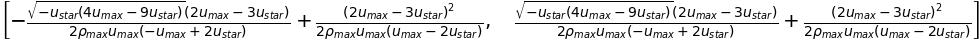

In [248]:
# We are going to print the roots separtely since they are very large.
# First root is in this cell
# Second root is in next cell


A_sol

In [249]:
## Time to evaluate the new flux equation
# Define initial conditions

# Now we can numeriaclly evaluate each root of A with the above values
# Using the evalf() function, which you pass substitutions to like so:



A_val_0 = A_sol[0].evalf(subs={u_star: 0.7, u_max:1, rho_max:10})
A_val_0

In [250]:
A_val_1 = A_sol[1].evalf(subs={u_star:0.7, u_max: 1.0, rho_max:10.0})
A_val_1

In [251]:
A_val = max(A_val_0, A_val_1)
A_val

In [252]:
# Solve for B constant

B_val = B_solution.evalf(subs={rho_max:10., A: A_val})
B_val

In [259]:
# Cubic Flux Function
def cubic_flux(rho, u_max, A_val, B_val):
    F = rho*u_max*(1 - A_val * rho - B_val*rho**2)
    return F

In [268]:
type()

float

In [260]:
rho_max = 10.
u_max = 1.

L = 4 
nx = 81
nt = 30
dx = L / (nx - 1)
x = np.linspace(0, L, num=nx)

In [261]:
rho0 = np.zeros_like(x)         #creates an array filled with zeros of same size as x
mask = np.where(x < 2.0)                   # creates a mask for all values of x < 2.0
rho0[mask] = rho_max * x[mask] / 2

In [262]:
#pyplot.plot(x, rho0);
print(A_val, B_val)

0.0146107219255619 0.00853892780744381


In [263]:
# Now to implement FTBS functions
# Given some initial density and some initial time step, return the history of the solution over the time steps

def ftbs(rho0, nt, dt, dx, cubic_flux, *args):
    rho_hist = [rho0.copy()]
    rho = rho0.copy
    for n in range(nt):
        F = cubic_flux(rho, *args)
        rho[1:] = rho[1:] - dt/ dx * (F[1:] - F[:-1])
        rho_hist.append(rho.copy())
    return rho_hist

In [264]:
sigma = 1.0
dt = sigma * dx/ u_max

rho_hist = ftbs(rho0, nt, dt, dx, cubic_flux, u_max, A_max_val, B_val)

TypeError: unsupported operand type(s) for *: 'builtin_function_or_method' and 'float'

In [201]:
## *Args example
def myfunction(*args):
    print(type(args))
    print(*args)
    return

In [161]:
myfunction(1)

<class 'tuple'>
1


In [143]:
myfunction(1, 2)

<class 'tuple'>
1 2


In [216]:
## Screw Args

In [226]:
def lax_fried(rho_0, nt, dt, dx, cubic_flux, *args):
    rho_hist = [rho_0.copy()]
    rho = rho_0.copy()
    nx = len(rho_0)
    for n in range(nt):
        rhon = rho.copy()
        F = cubic_flux(u_max, *args)
        for i in range(1, nx-1):
            rho[i] = (0.5 * (rhon[i-1] + rhon[i+1]) - dt * (F[i+1] - F[i-1]) / (2*dx))   
            
        rho_hist.append(rho.copy())
    
    return rho_hist

In [227]:
lax_fried(rho0, nt, dt, dx, u_max, rho_max)

TypeError: 'float' object is not callable